In [139]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import model.profile_models as profile_models
import model.train_profile_model as train_profile_model
import model.profile_performance as profile_performance
import feature.util as feature_util
import feature.make_profile_dataset as make_profile_dataset
import keras
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import plot_model
import json
import hashlib
hashfn = lambda x: hashlib.sha1(str(x).encode()).hexdigest()

### Define paths for the model and data of interest

In [164]:
# Define the paths to the peak BEDs and profile BigWigs
base_path = "/users/amtseng/tfmodisco/data/interim/ENCODE/"

peaks_bed = os.path.join(base_path, "SPI1/SPI1_ENCSR000BGQ_GM12878_train_peakints.bed.gz")

prof_bigwigs = [
    (os.path.join(base_path, e_1), os.path.join(base_path, e_2)) \
    for e_1, e_2 in [
        ("SPI1/SPI1_ENCSR000BGQ_GM12878_neg.bw",
        "SPI1/SPI1_ENCSR000BGQ_GM12878_pos.bw"),
        ("SPI1/SPI1_ENCSR000BGW_K562_neg.bw",
        "SPI1/SPI1_ENCSR000BGW_K562_pos.bw"),
        ("SPI1/SPI1_ENCSR000BIJ_GM12891_neg.bw",
        "SPI1/SPI1_ENCSR000BIJ_GM12891_pos.bw"),
        ("SPI1/SPI1_ENCSR000BUW_HL-60_neg.bw",
        "SPI1/SPI1_ENCSR000BUW_HL-60_pos.bw"),
        ("SPI1/control_ENCSR000BGH_GM12878_neg.bw",
        "SPI1/control_ENCSR000BGH_GM12878_pos.bw"),
        ("SPI1/control_ENCSR000BGG_K562_neg.bw",
        "SPI1/control_ENCSR000BGG_K562_pos.bw"),
        ("SPI1/control_ENCSR000BIH_GM12891_neg.bw",
        "SPI1/control_ENCSR000BIH_GM12891_pos.bw"),
        ("SPI1/control_ENCSR000BVU_HL-60_neg.bw",
        "SPI1/control_ENCSR000BVU_HL-60_pos.bw")
    ]
]

num_tasks = int(len(prof_bigwigs) / 2)
# Path to saved model
model_dir = "/users/amtseng/tfmodisco/models/trained_models/SPI1_nocounts_nohyperparam/18/"
model_path = os.path.join(model_dir, "model_ckpt_end.h5")

In [5]:
# Define some constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
input_length = 1346
profile_length = 1000
num_tasks = 4

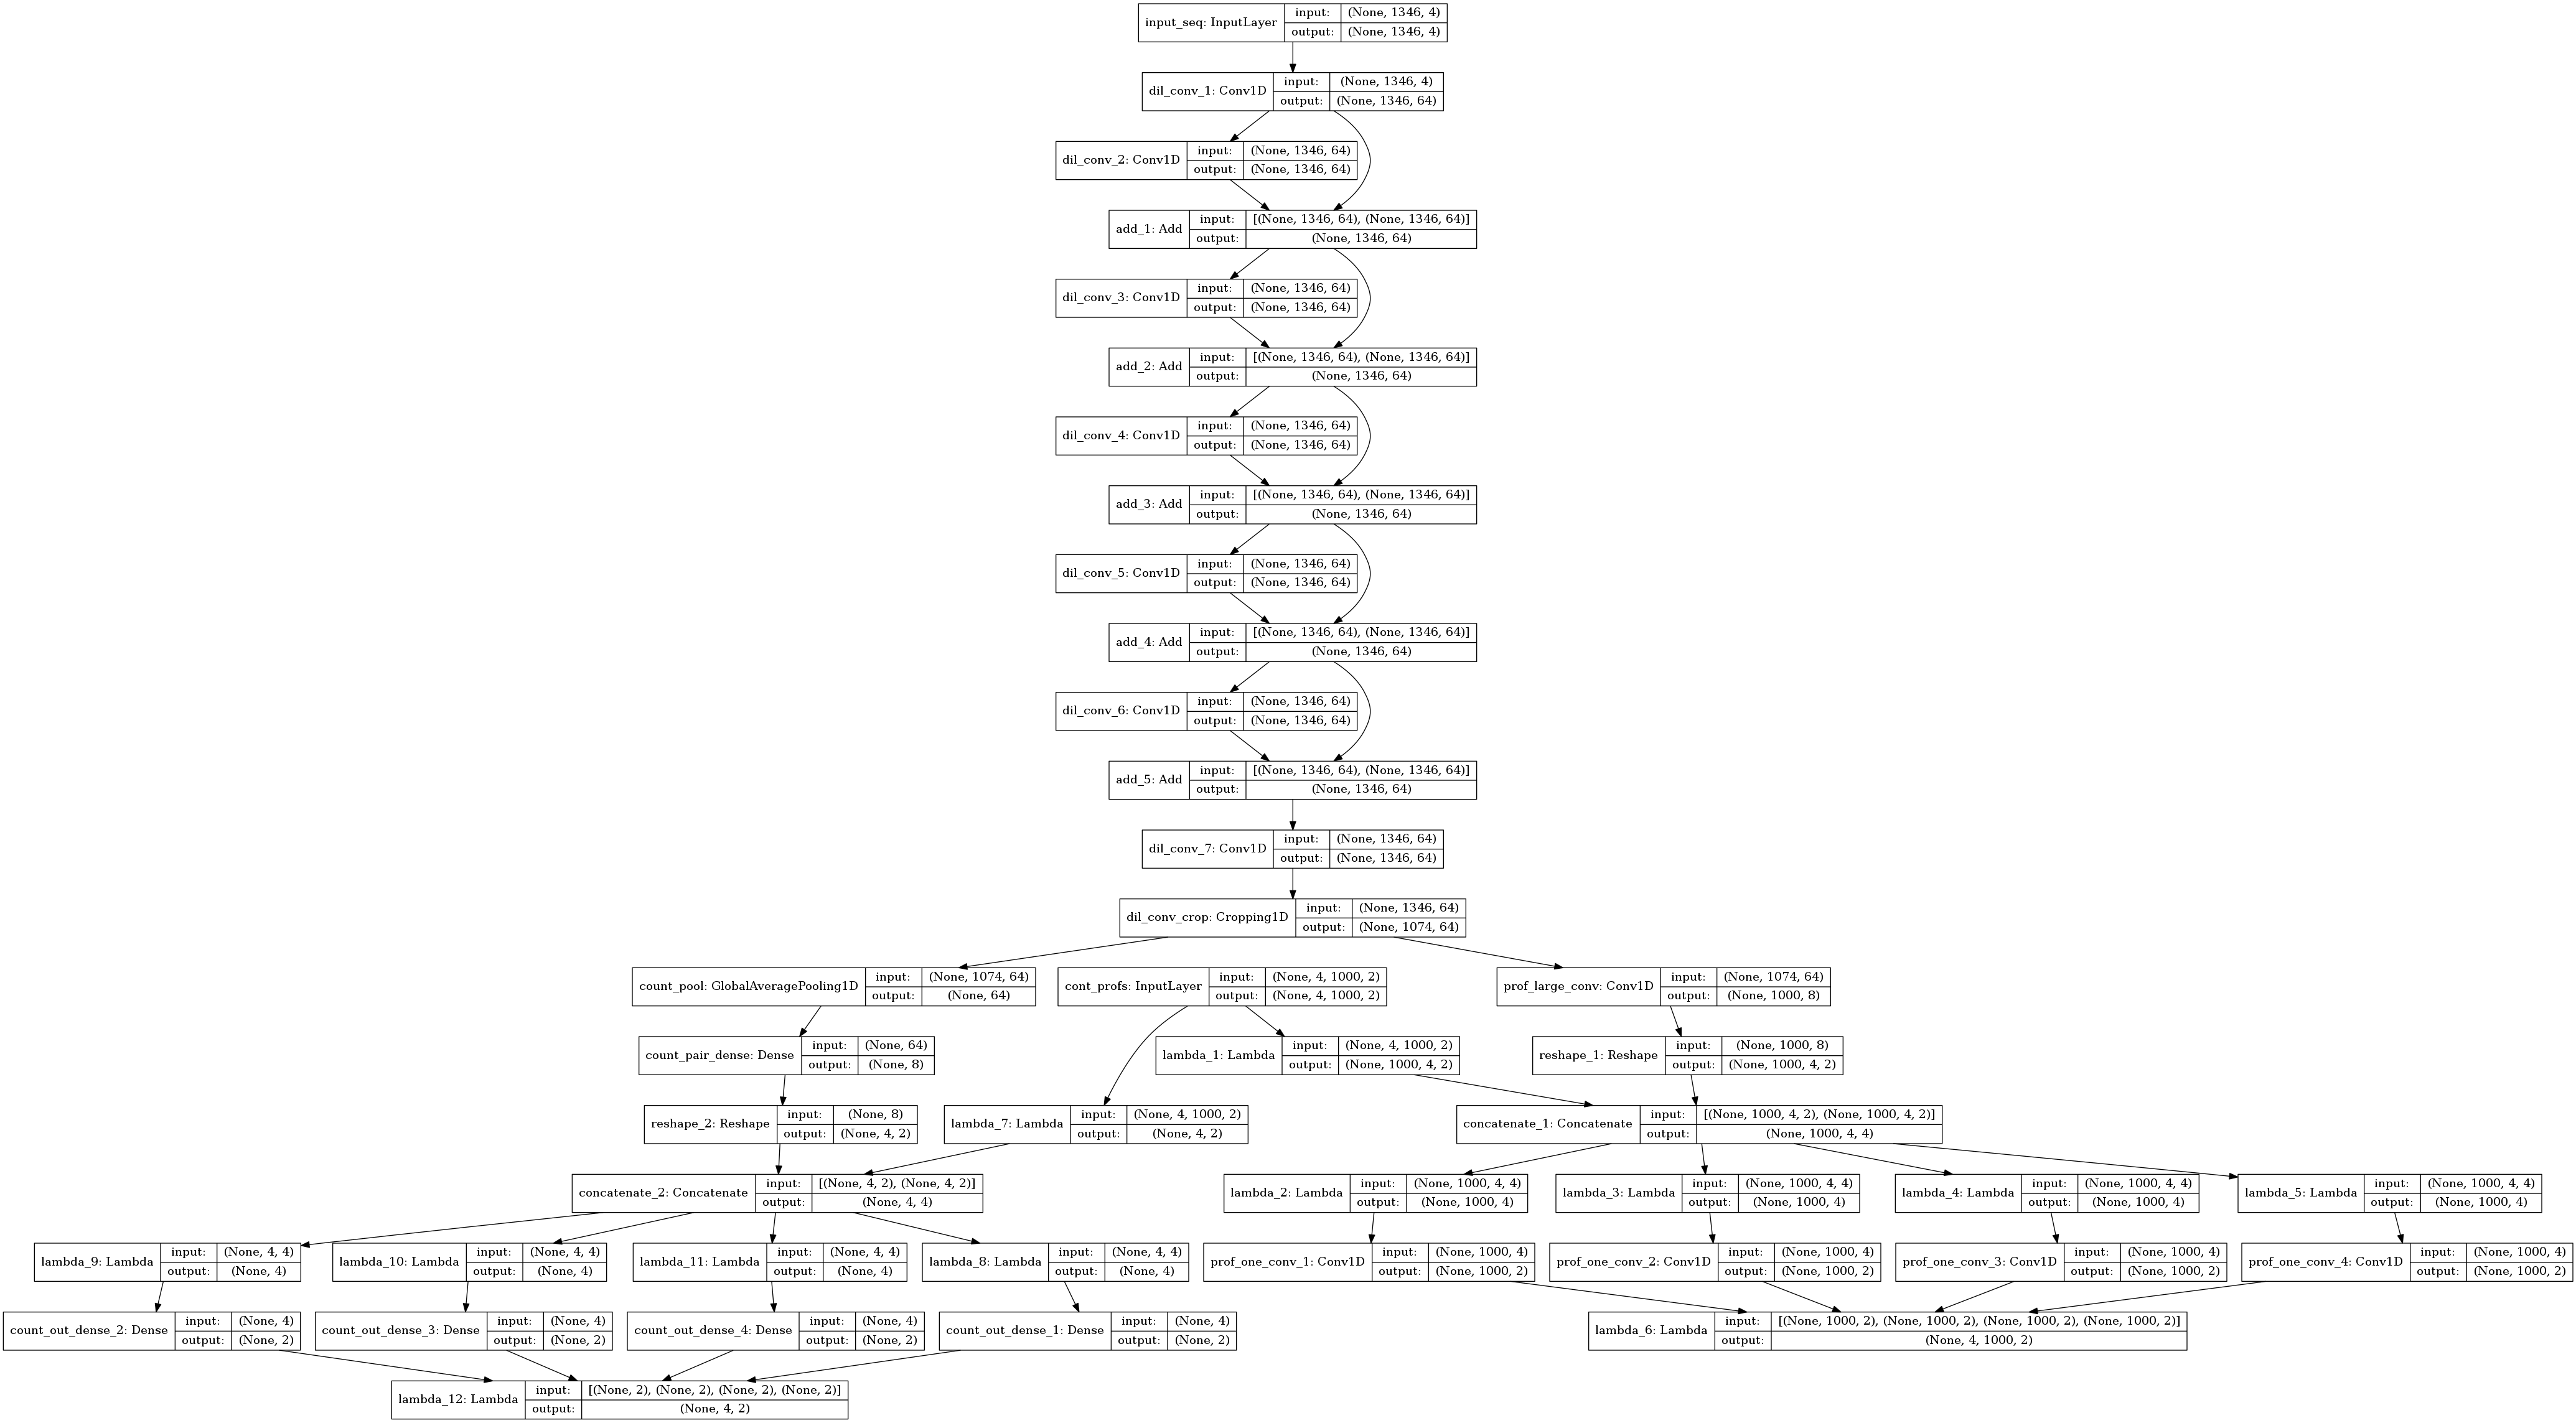

In [165]:
# Import the model
custom_objects = {
    "tf": tf,
    "profile_loss": train_profile_model.get_profile_loss_function(num_tasks, profile_length),
    "count_loss": train_profile_model.get_count_loss_function(num_tasks)
}
model = keras.models.load_model(model_path, custom_objects=custom_objects)
plot_model(model, show_shapes=True)

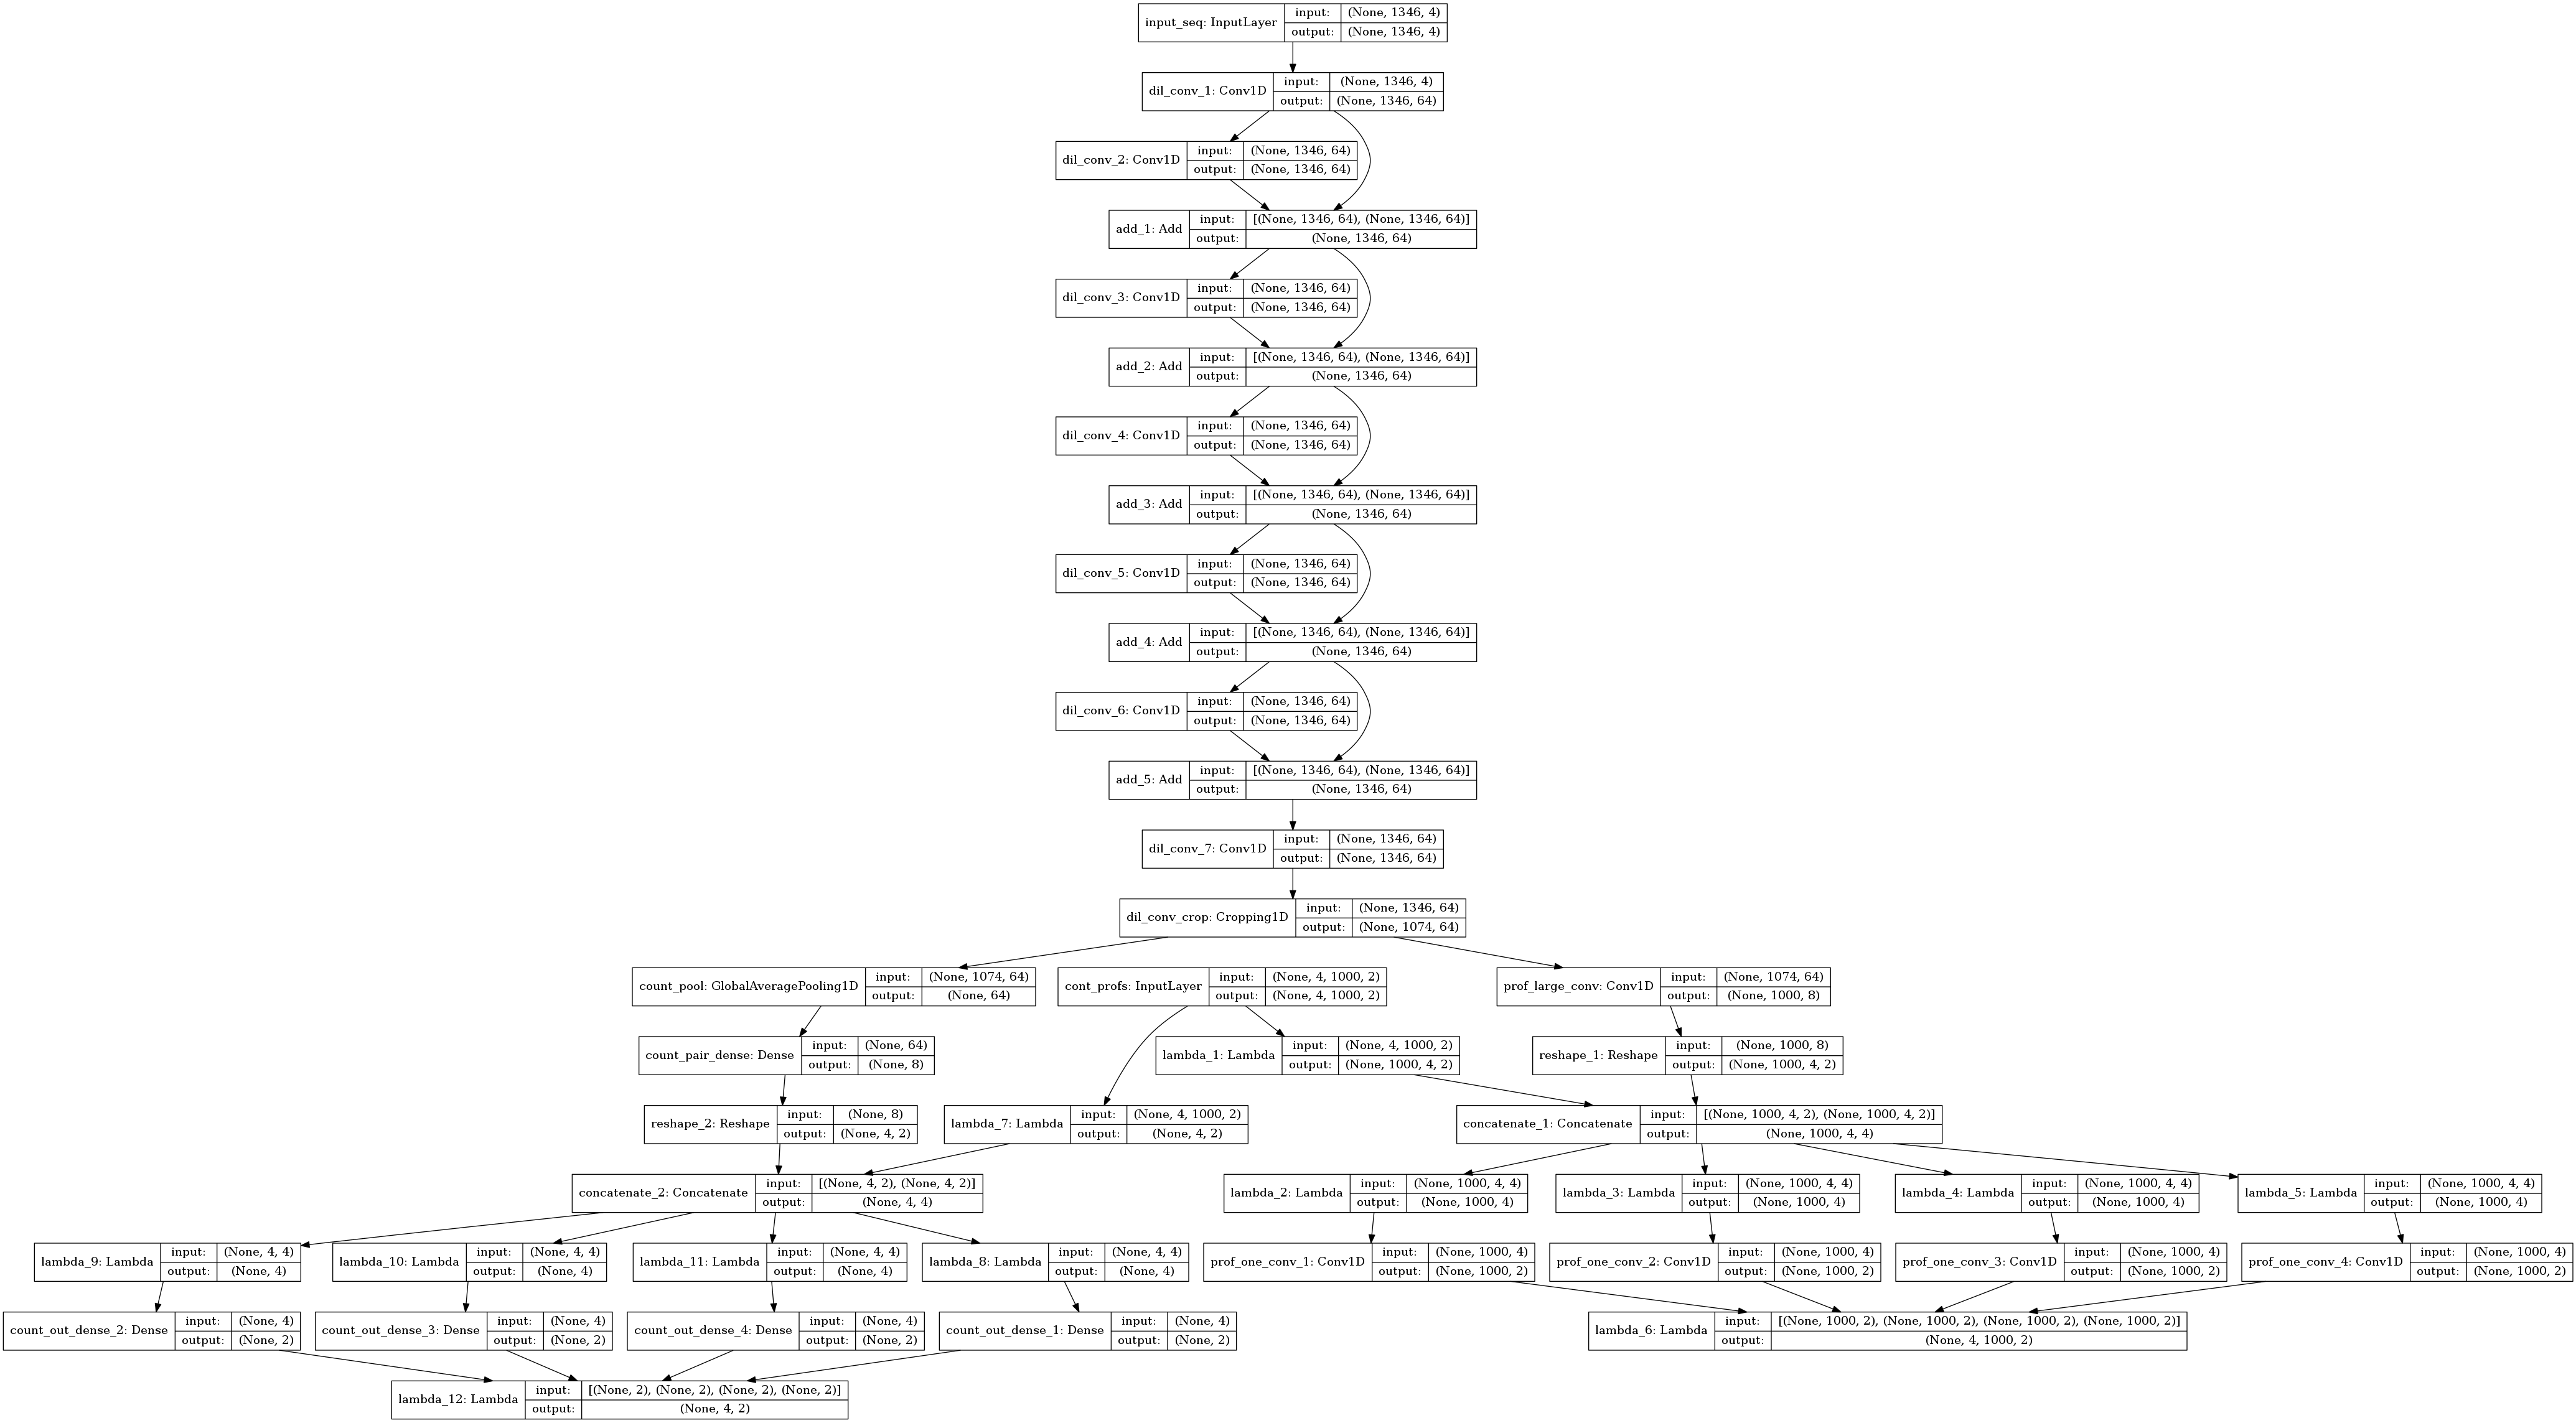

In [171]:
# Import the model (alternate method)
custom_objects = {
    "tf": tf,
    "profile_loss": train_profile_model.get_profile_loss_function(num_tasks, profile_length),
    "count_loss": train_profile_model.get_count_loss_function(num_tasks)
}
with open(model_dir + "/model_arch_end.json", "r") as f:
    model_json = f.read()
model = keras.models.model_from_json(model_json, custom_objects=custom_objects)
model.load_weights(model_dir + "/model_weights_end.h5")
 
# evaluate loaded model on test data
model.compile(optimizer="rmsprop", loss="mse")  # Fake shit
plot_model(model, show_shapes=True)

In [166]:
# Import saved outputs
saved_true_profs = np.load(model_dir + "/true_profs.npy")
saved_log_pred_profs = np.load(model_dir + "/log_pred_profs.npy")
saved_true_counts = np.load(model_dir + "/true_counts.npy")
saved_log_pred_counts = np.load(model_dir + "/log_pred_counts.npy")
saved_inputs = np.load(model_dir + "/inputs.npy")
saved_profiles = np.load(model_dir + "/profiles.npy")
with open(model_dir + "/metrics.json", "r") as f:
    metrics = json.load(f)
saved_coords = np.array(metrics["summit_coords"]["values"][0]["values"], dtype=object)

### Data preparation
Use classes from `make_profile_dataset` to prepare positive and negative inputs.

In [9]:
# Maps coordinates to 1-hot encoded sequence
coords_to_seq = feature_util.CoordsToSeq(reference_fasta, center_size_to_use=input_length)

# Maps coordinates to profiles, in order of BigWigs given in `prof_bigwigs`
coords_to_vals_list = [
    (
        make_profile_dataset.CoordsToVals(path_1, profile_length),
        make_profile_dataset.CoordsToVals(path_2, profile_length)
    )
    for path_1, path_2 in prof_bigwigs
]
def coords_to_profs(coords):
    return np.stack([
        np.stack([ctv_1(coords), ctv_2(coords)], axis=2)
        for ctv_1, ctv_2 in coords_to_vals_list
    ], axis=1)
# Maps many coordinates to inputs sequences and profiles for the network
def coords_to_network_inputs(coords):
    input_seq = coords_to_seq(coords)
    profs = coords_to_profs(coords)
    return input_seq, profs

In [10]:
# Import set of positive peaks
pos_coords_table = pd.read_csv(peaks_bed, sep="\t", header=None, compression="gzip")

# Negative coordinate sampling
neg_coord_sampler = make_profile_dataset.GenomeIntervalSampler(chrom_sizes, input_length)

### Predicting and plotting profiles

In [97]:
def predict_coords(coords, expand_to_batch=False):
    """
    Fetches the necessary data from the given coordinate and runs it through the
    network. Returns the network predictions AND the true values from the dataset.
    The returned predicted profiles are in terms of log probabilities, and the
    returned predicted counts are also log. Returned values are all NumPy arrays.
    """
    input_seq, profiles = coords_to_network_inputs(coords)
    
    # Expand to full batch
    if expand_to_batch:
        input_seq = np.tile(input_seq, (256, 1, 1))
        profiles = np.tile(profiles, (256, 1, 1, 1))
    
    true_profs = profiles[:, :num_tasks, :, :]
    cont_profs = profiles[:, num_tasks:, :, :]
    true_counts = np.sum(true_profs, axis=2)
    
    # Run through the model
    logit_pred_profs, log_pred_counts = model.predict_on_batch([input_seq, cont_profs])
    
    # Convert logit profile predictions to probabilities
    log_pred_profs = profile_models.profile_logits_to_log_probs(
        logit_pred_profs
    )
    
    if expand_to_batch:
        return log_pred_profs[:1], log_pred_counts[:1], true_profs[:1], true_counts[:1], input_seq[:1], profiles[:1]
    return log_pred_profs, log_pred_counts, true_profs, true_counts, input_seq, profiles

In [19]:
def plot_profiles(pred_profs, true_profs, normalize=True, title=None):
    """
    Plots the given profiles.
    Both arguments should be T x O x 2 NumPy arrays, where the subarrays are the
    tracks for the plus and minus strand, for each task.
    If `normalize` is True, normalize the profiles to be probabilities (i.e.
    each track sums to 1)
    """
    pred_profs, true_profs = np.squeeze(pred_profs), np.squeeze(true_profs)
    num_tasks, prof_length = pred_profs.shape[0], pred_profs.shape[1]
    if normalize:
        pred_profs = pred_profs / np.sum(pred_profs, axis=1, keepdims=True)
        true_profs = true_profs / np.sum(true_profs, axis=1, keepdims=True)
    fig, ax = plt.subplots(num_tasks, figsize=(15, 20))
    for i in range(num_tasks):
        ax[i].plot(true_profs[i,:,0], color="royalblue", alpha=0.5)
        ax[i].plot(-true_profs[i,:,1], color="goldenrod", alpha=0.5)
        ax[i].plot(pred_profs[i,:,0], color="darkslateblue")
        ax[i].plot(-pred_profs[i,:,1], color="darkorange")
    if title:
        fig.suptitle(title)

### View predictions

In [ ]:
# Sample some positive coordinates
pos_coords_table.sample(10)

In [ ]:
# Sample some negative coordinates
neg_coord_sampler.sample_intervals(10)

/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/users/amtseng/miniconda3/envs/tfmodisco/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


[[ 0.          5.62624097 27.14375068 61.51290162]]
[[       nan 0.61610369 0.65054806 0.32334767]]
[[ 0.          5.37924933 14.64476706 61.16737063]]
[[       nan 0.60960088 0.50935003 0.3227287 ]]
41.0
41.0


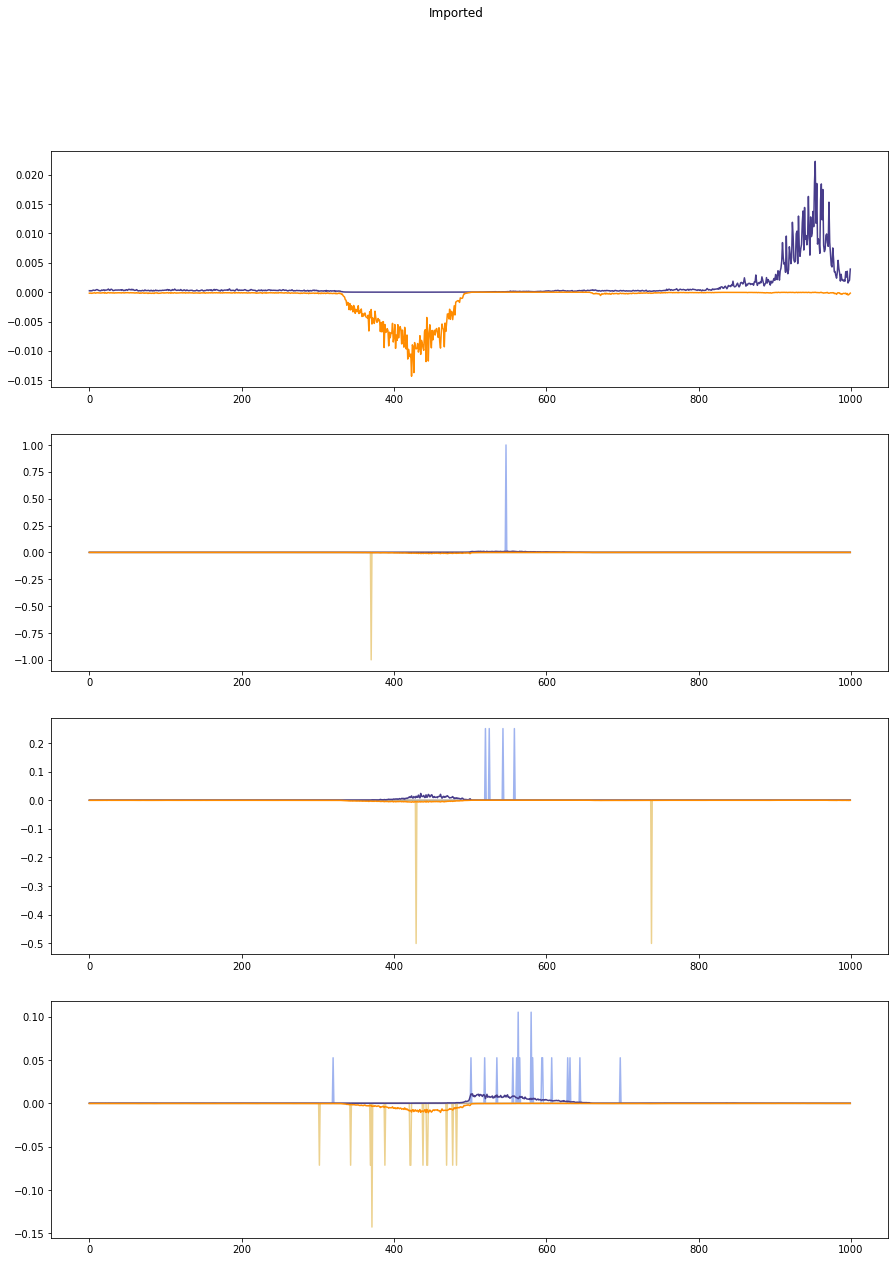

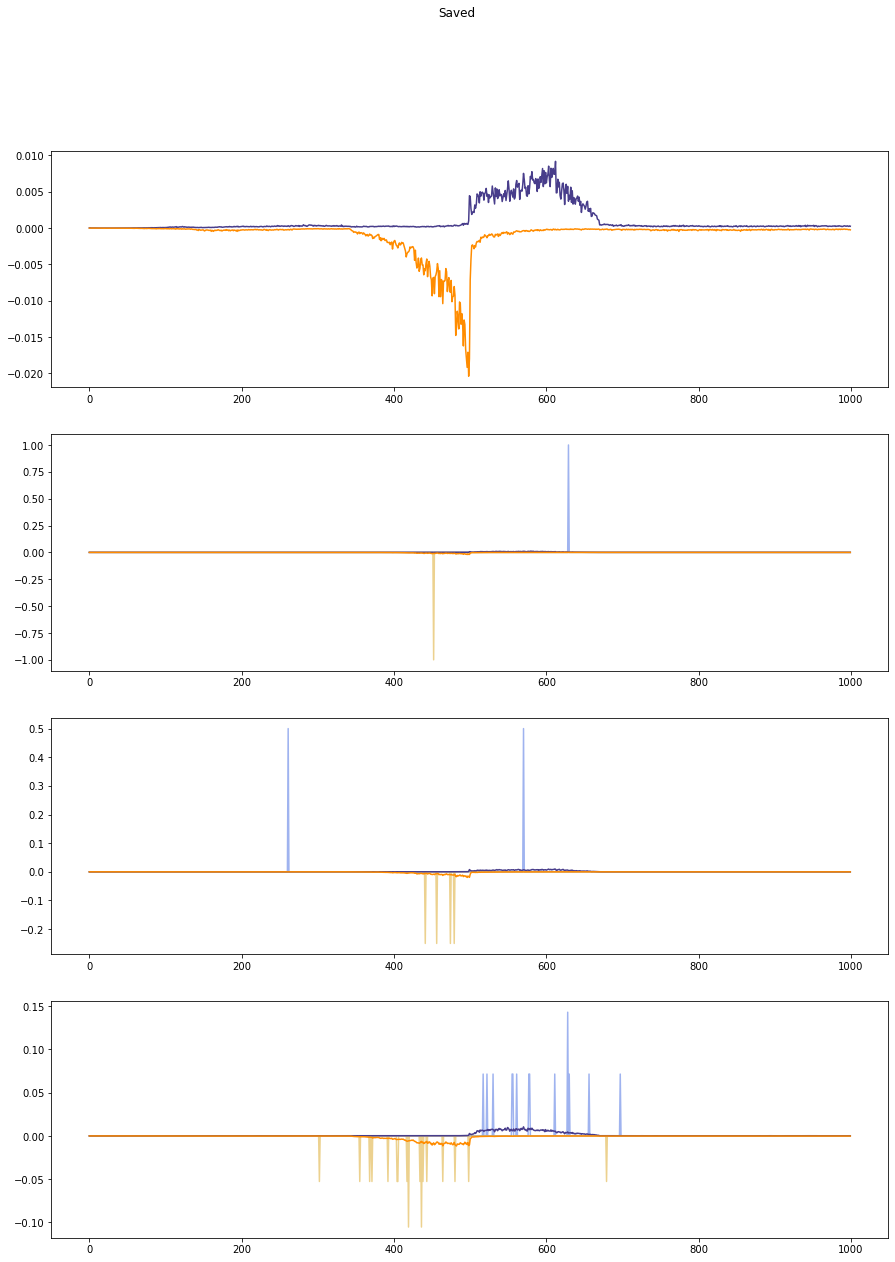

In [38]:
log_pred_profs, log_pred_counts, true_profs, true_counts = predict_coords([("chr1", 196823400, 196824400)])
index = 49661
s_log_pred_profs, s_log_pred_counts = saved_log_pred_profs[index:index + 1], saved_log_pred_counts[index:index + 1]
s_true_profs, s_true_counts = saved_true_profs[index:index + 1], saved_true_counts[index:index + 1]

pred_prof_probs = np.exp(log_pred_profs)
true_prof_probs = true_profs / np.sum(true_profs, axis=2, keepdims=True)

s_pred_prof_probs = np.exp(s_log_pred_profs)
s_true_prof_probs = s_true_profs / np.sum(s_true_profs, axis=2, keepdims=True)

print(profile_performance.profile_multinomial_nll(true_profs, log_pred_profs, true_counts))
print(profile_performance.profile_jsd(true_prof_probs, pred_prof_probs, 3))
print(profile_performance.profile_multinomial_nll(s_true_profs, s_log_pred_profs, s_true_counts))
print(profile_performance.profile_jsd(s_true_prof_probs, s_pred_prof_probs, 3))

plot_profiles(pred_prof_probs, true_prof_probs, normalize=True, title="Imported")
plot_profiles(s_pred_prof_probs, s_true_prof_probs, normalize=True, title="Saved")

[[157.6238426   87.02054436 136.06376944  85.63712561]]
[[0.48712659 0.46301333 0.48366432 0.44602138]]
[[97.35714615 83.12716849 72.80230842 85.63712561]]
[[0.26497482 0.44256389 0.27082343 0.44602138]]


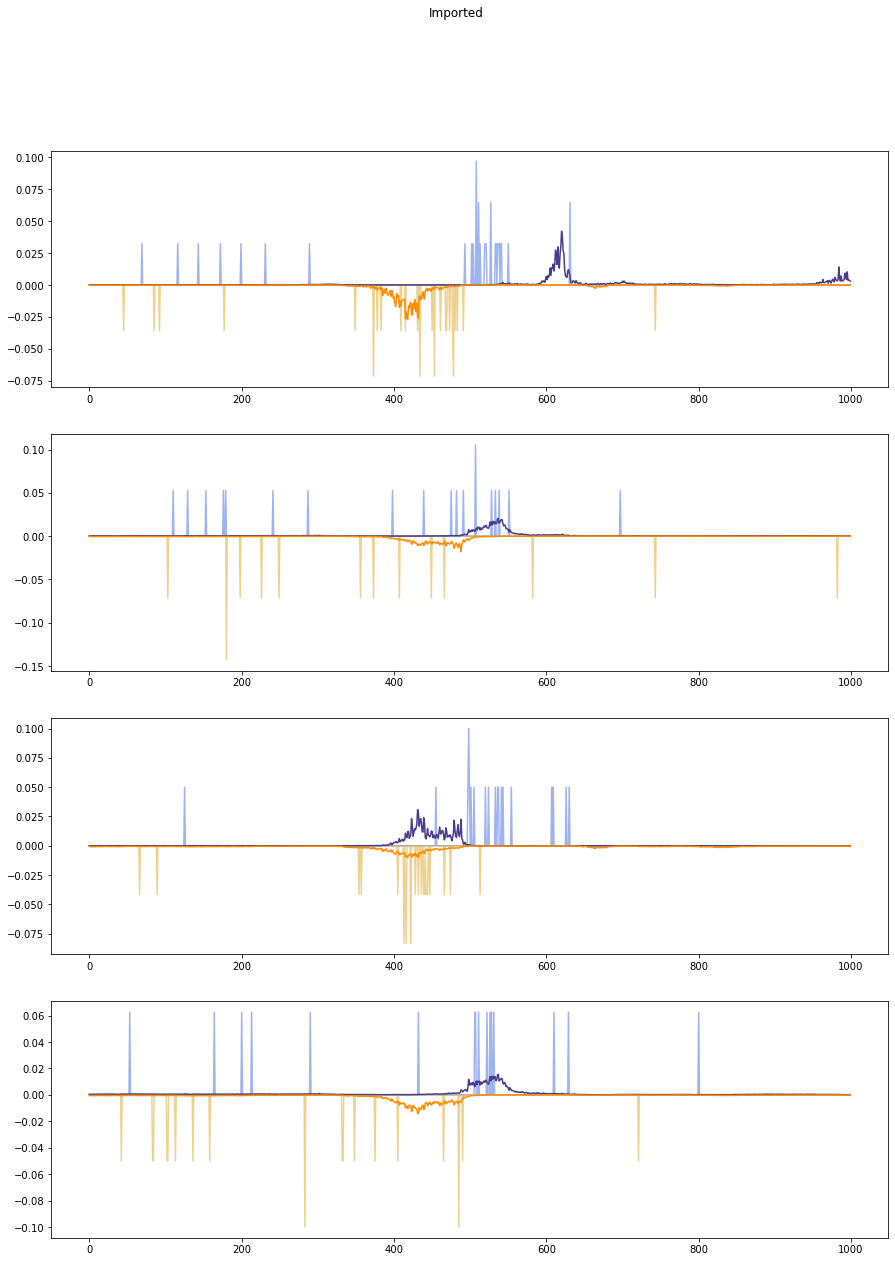

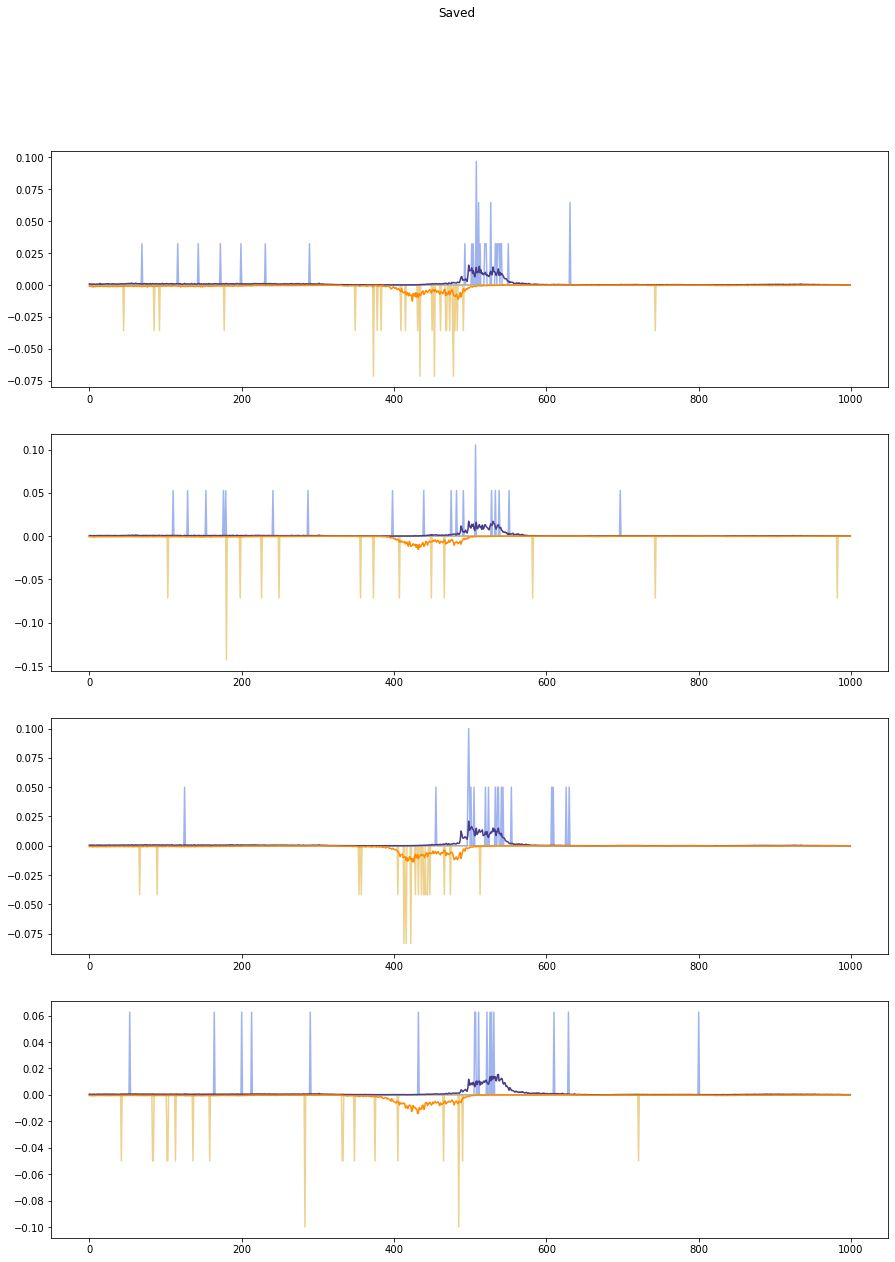

In [35]:
log_pred_profs, log_pred_counts, true_profs, true_counts = predict_coords([("chr1", 1001879, 1002879)])
index = 3
s_log_pred_profs, s_log_pred_counts = saved_log_pred_profs[index:index + 1], saved_log_pred_counts[index:index + 1]
s_true_profs, s_true_counts = saved_true_profs[index:index + 1], saved_true_counts[index:index + 1]

pred_prof_probs = np.exp(log_pred_profs)
true_prof_probs = true_profs / np.sum(true_profs, axis=2, keepdims=True)

s_pred_prof_probs = np.exp(s_log_pred_profs)
s_true_prof_probs = s_true_profs / np.sum(s_true_profs, axis=2, keepdims=True)

print(profile_performance.profile_multinomial_nll(true_profs, log_pred_profs, true_counts))
print(profile_performance.profile_jsd(true_prof_probs, pred_prof_probs, 3))
print(profile_performance.profile_multinomial_nll(s_true_profs, s_log_pred_profs, s_true_counts))
print(profile_performance.profile_jsd(s_true_prof_probs, s_pred_prof_probs, 3))

plot_profiles(pred_prof_probs, true_prof_probs, normalize=True, title="Imported")
plot_profiles(s_pred_prof_probs, s_true_prof_probs, normalize=True, title="Saved")

[[602.70643011 311.1595569  770.50145363 521.46680809]]
[[0.3112642  0.22867425 0.39064147 0.18016631]]
[[484.81915036 329.60544184 486.2425754  521.46680809]]
[[0.26409743 0.26525789 0.21281662 0.1801663 ]]


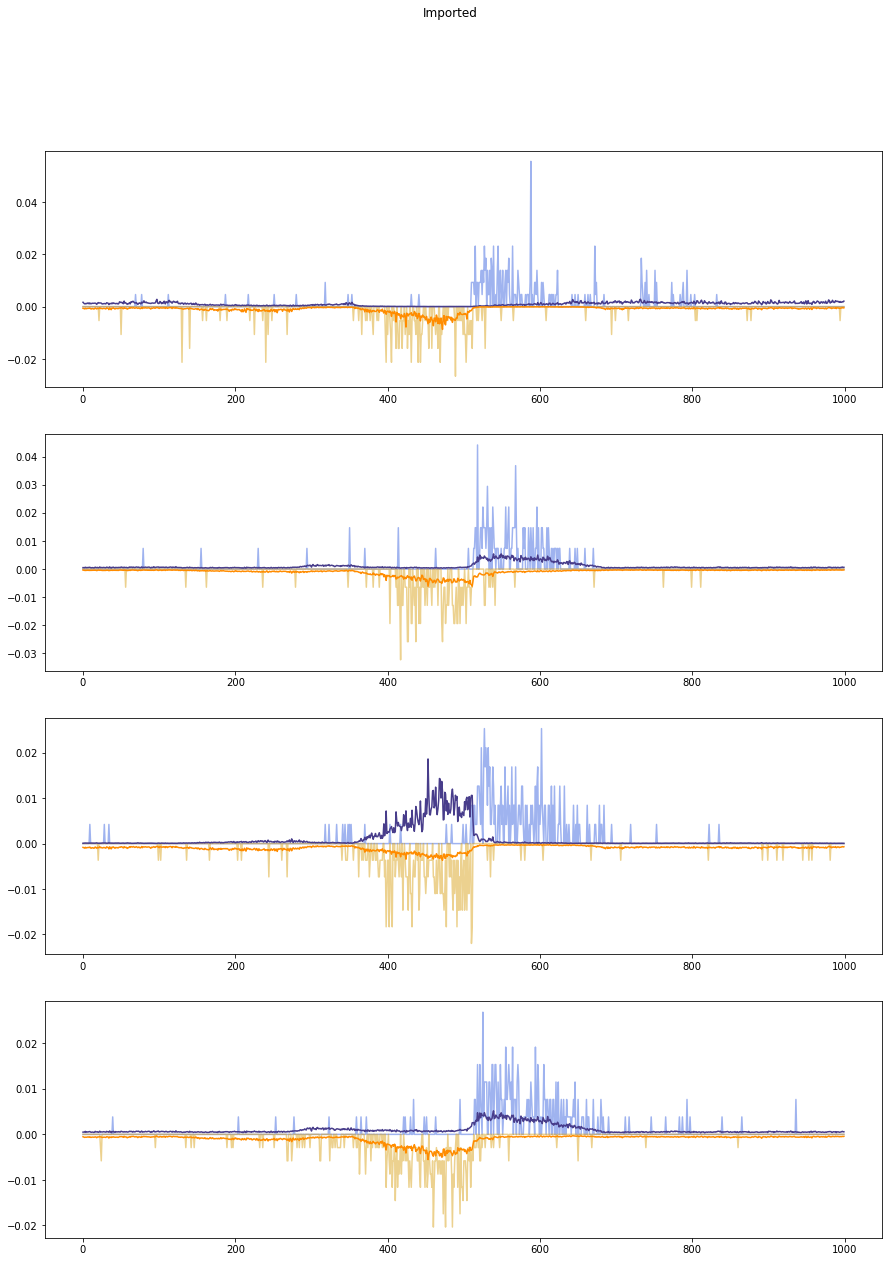

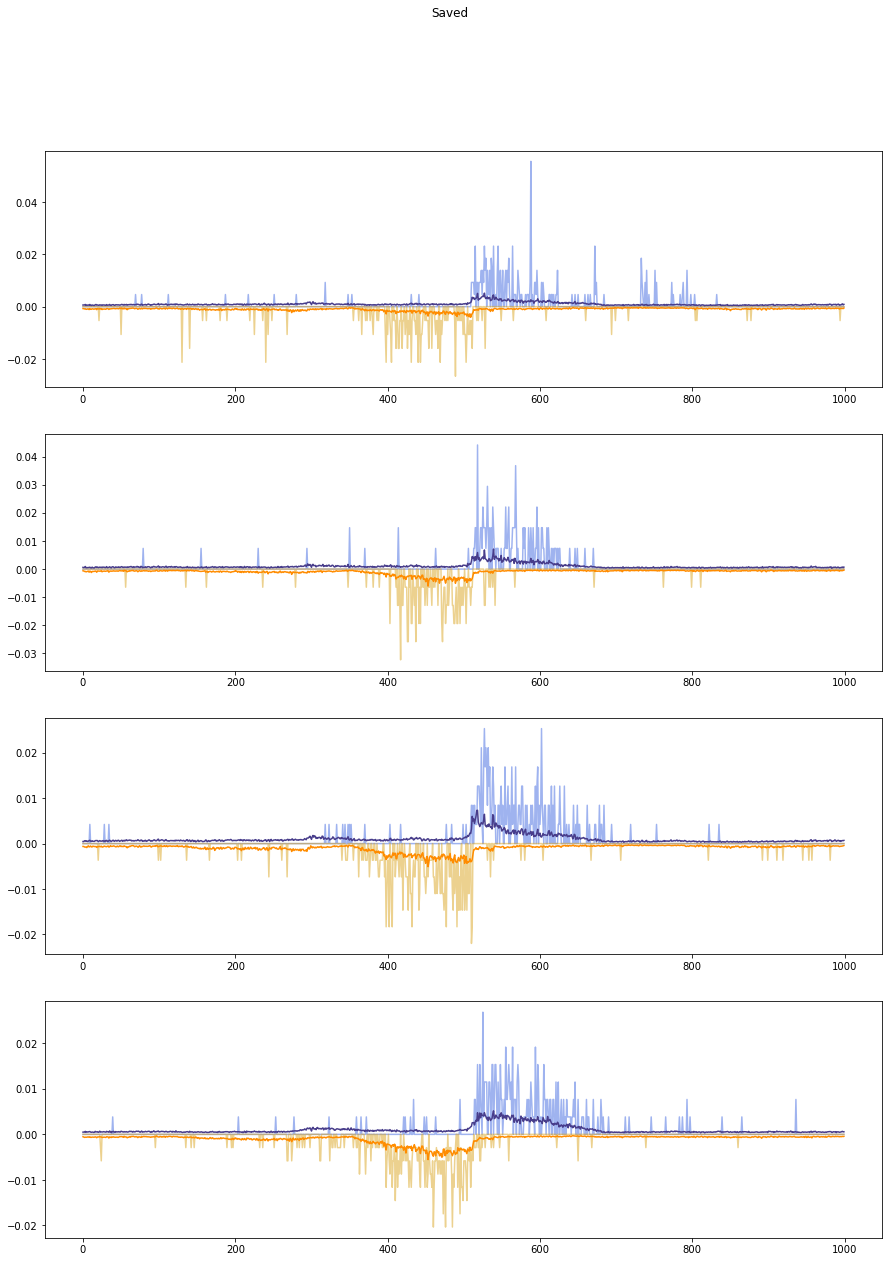

In [36]:
log_pred_profs, log_pred_counts, true_profs, true_counts = predict_coords([("chr1", 2290389, 2291389)])
index = 30
s_log_pred_profs, s_log_pred_counts = saved_log_pred_profs[index:index + 1], saved_log_pred_counts[index:index + 1]
s_true_profs, s_true_counts = saved_true_profs[index:index + 1], saved_true_counts[index:index + 1]

pred_prof_probs = np.exp(log_pred_profs)
true_prof_probs = true_profs / np.sum(true_profs, axis=2, keepdims=True)

s_pred_prof_probs = np.exp(s_log_pred_profs)
s_true_prof_probs = s_true_profs / np.sum(s_true_profs, axis=2, keepdims=True)

print(profile_performance.profile_multinomial_nll(true_profs, log_pred_profs, true_counts))
print(profile_performance.profile_jsd(true_prof_probs, pred_prof_probs, 3))
print(profile_performance.profile_multinomial_nll(s_true_profs, s_log_pred_profs, s_true_counts))
print(profile_performance.profile_jsd(s_true_prof_probs, s_pred_prof_probs, 3))

plot_profiles(pred_prof_probs, true_prof_probs, normalize=True, title="Imported")
plot_profiles(s_pred_prof_probs, s_true_prof_probs, normalize=True, title="Saved")

[[168.00485999  87.33897631 137.59021302 157.18803653]]
[[0.55401713 0.60747038 0.46399085 0.35228253]]
[[123.72796399  64.08263533 116.91674133 157.18803653]]
[[0.37445044 0.44987512 0.35667241 0.35228253]]

True
True


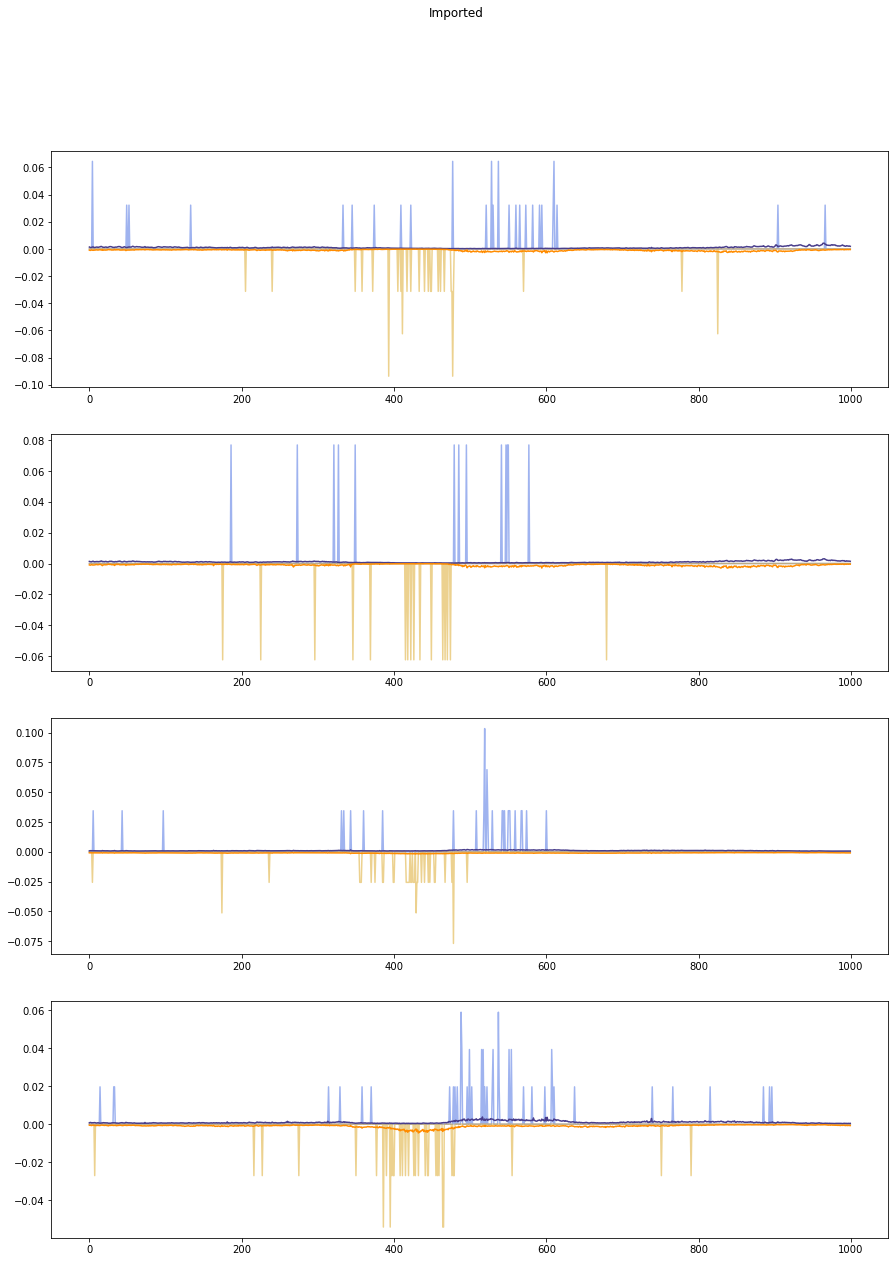

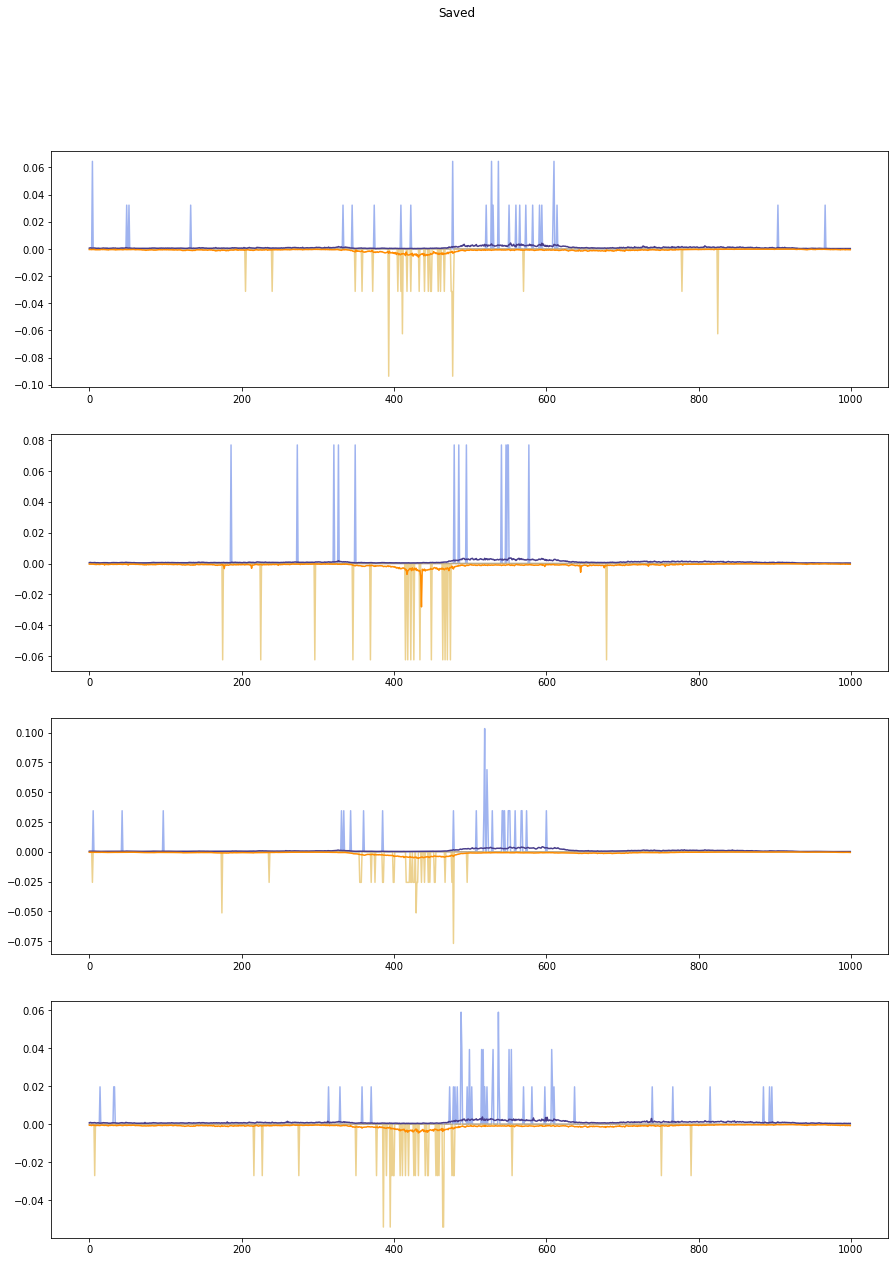

In [92]:
index = 100
s_log_pred_profs, s_log_pred_counts = saved_log_pred_profs[index:index + 1], saved_log_pred_counts[index:index + 1]
s_true_profs, s_true_counts = saved_true_profs[index:index + 1], saved_true_counts[index:index + 1]
s_inputs, s_profiles = saved_inputs[index:index + 1], saved_profiles[index:index + 1]

log_pred_profs, log_pred_counts, true_profs, true_counts, inputs, profiles = predict_coords(saved_coords[index:index + 1])

pred_prof_probs = np.exp(log_pred_profs)
true_prof_probs = true_profs / np.sum(true_profs, axis=2, keepdims=True)

s_pred_prof_probs = np.exp(s_log_pred_profs)
s_true_prof_probs = s_true_profs / np.sum(s_true_profs, axis=2, keepdims=True)

print(profile_performance.profile_multinomial_nll(true_profs, log_pred_profs, true_counts))
print(profile_performance.profile_jsd(true_prof_probs, pred_prof_probs, 3))
print(profile_performance.profile_multinomial_nll(s_true_profs, s_log_pred_profs, s_true_counts))
print(profile_performance.profile_jsd(s_true_prof_probs, s_pred_prof_probs, 3))

print("")

print(np.all(inputs == s_inputs))
print(np.all(profiles == s_profiles))

plot_profiles(pred_prof_probs, true_prof_probs, normalize=True, title="Imported")
plot_profiles(s_pred_prof_probs, s_true_prof_probs, normalize=True, title="Saved")

True
True
False
False


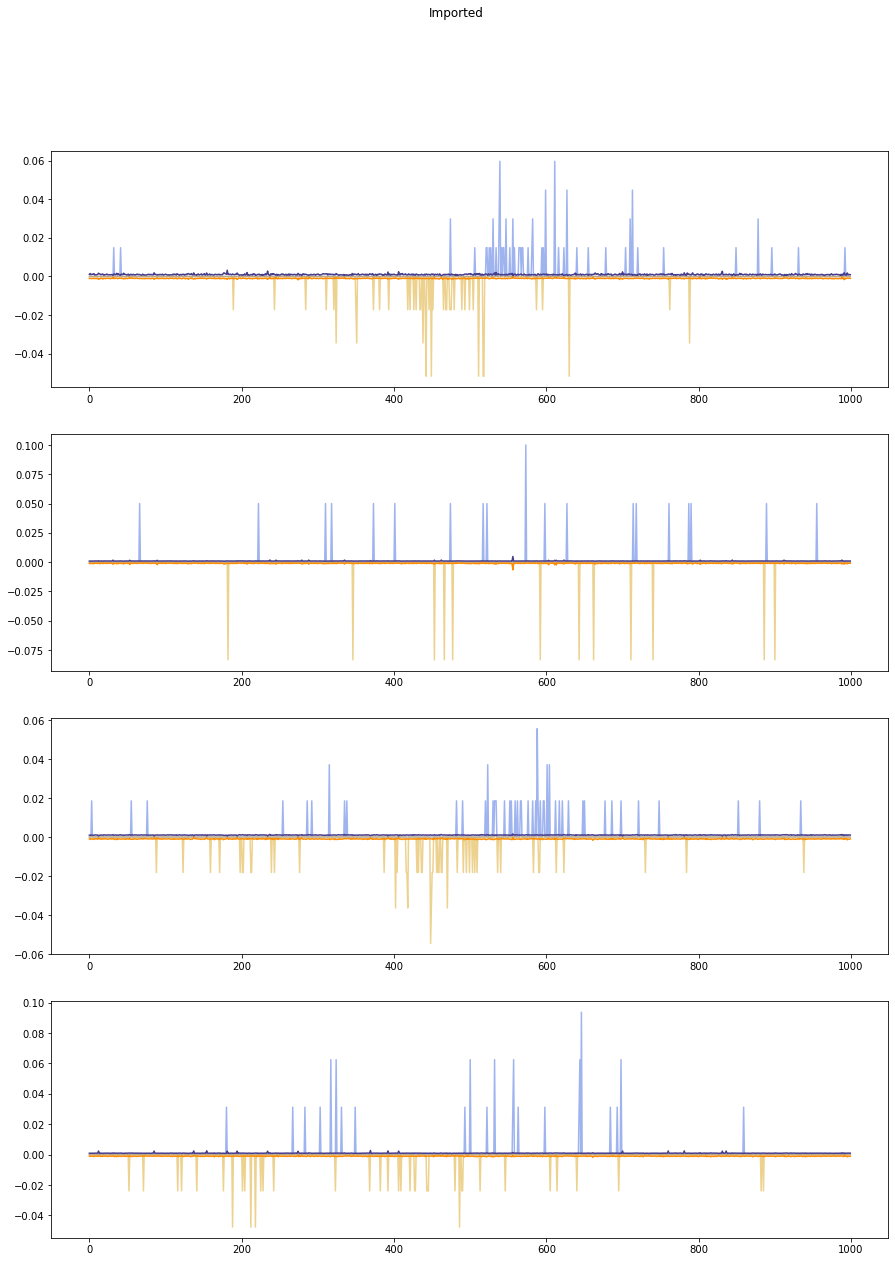

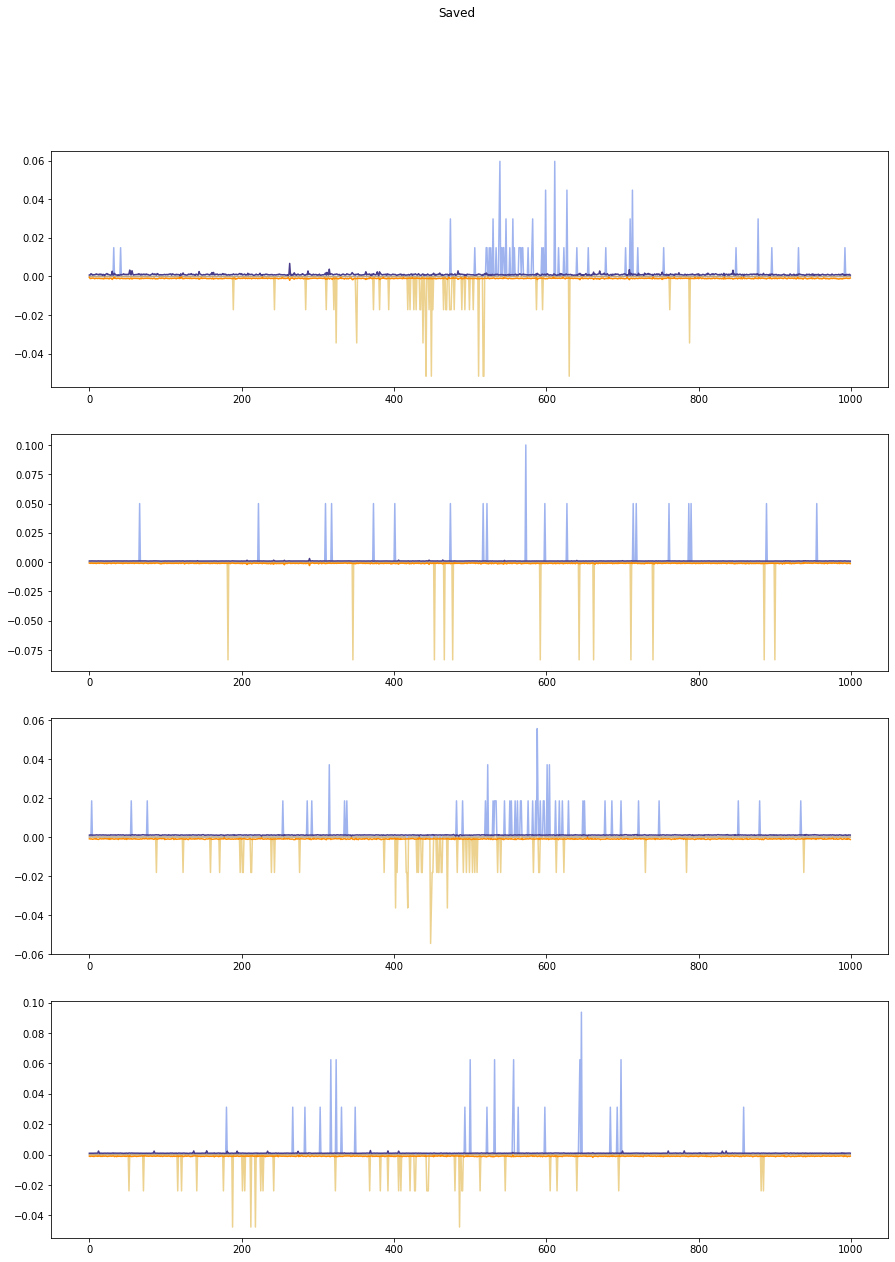

In [137]:
# First batch
s_log_pred_profs, s_log_pred_counts = saved_log_pred_profs[:128], saved_log_pred_counts[:128]
s_true_profs, s_true_counts = saved_true_profs[:128], saved_true_counts[:128]
s_inputs, s_profiles = saved_inputs[:128], saved_profiles[:128]

log_pred_profs, log_pred_counts, true_profs, true_counts, inputs, profiles = predict_coords(saved_coords[:128])

pred_prof_probs = np.exp(log_pred_profs)
true_prof_probs = true_profs / np.sum(true_profs, axis=2, keepdims=True)

s_pred_prof_probs = np.exp(s_log_pred_profs)
s_true_prof_probs = s_true_profs / np.sum(s_true_profs, axis=2, keepdims=True)

# print(profile_performance.profile_multinomial_nll(true_profs, log_pred_profs, true_counts))
# print(profile_performance.profile_jsd(true_prof_probs, pred_prof_probs, 3))
# print(profile_performance.profile_multinomial_nll(s_true_profs, s_log_pred_profs, s_true_counts))
# print(profile_performance.profile_jsd(s_true_prof_probs, s_pred_prof_probs, 3))

print(np.all(inputs == s_inputs))
print(np.all(profiles == s_profiles))
print(np.allclose(log_pred_profs, s_log_pred_profs))
print(np.allclose(log_pred_counts, s_log_pred_counts))

plot_profiles(pred_prof_probs[-1:], true_prof_probs[-1:], normalize=True, title="Imported")
plot_profiles(s_pred_prof_probs[-1:], s_true_prof_probs[-1:], normalize=True, title="Saved")

In [172]:
# Check hashes
print("Hash of weights:")
print(hashfn(model.get_weights()))
print("")
print("Hashes of saved things")
print("Hash of inputs:")
print(hashfn(saved_inputs))
print("Hash of profiles:")
print(hashfn(saved_profiles))
print("Hash of log_pred_profs:")
print(hashfn(saved_log_pred_profs))
print(np.sum(saved_log_pred_profs))
print("Hash of log_pred_counts:")
print(hashfn(saved_log_pred_counts))
print(np.sum(saved_log_pred_counts))
print("")
print("Hashes of run things")

true_profs = saved_profiles[:, :num_tasks, :, :]
cont_profs = saved_profiles[:, num_tasks:, :, :]
logit_pred_profs, log_pred_counts = model.predict_on_batch([saved_inputs, cont_profs])
log_pred_profs = profile_models.profile_logits_to_log_probs(logit_pred_profs)

print("Hash of log_pred_profs:")
print(hashfn(log_pred_profs))
print(np.sum(log_pred_profs))
print("Hash of log_pred_counts:")
print(hashfn(log_pred_counts))
print(np.sum(log_pred_counts))

print(np.allclose(saved_log_pred_profs, log_pred_profs))

Hash of weights:
39b7d61f530f09d21de9c0db720ff113588e8f94

Hashes of saved things
Hash of inputs:
94130f87def87a9409865a70d37fb8ccca130747
Hash of profiles:
6db2307daf82892a6059ae43eebb0d766b16d394
Hash of log_pred_profs:
71693d80432a4056fdf9fefc680f08f1f35141ad
-14174179.233090878
Hash of log_pred_counts:
7634fd79fbc566fd3e0031a6a8779a3331c36131
-27500.183154776692

Hashes of run things
Hash of log_pred_profs:
696032b2794f276ca8d023e44e5ecab0cea390b0
-14173143.0
Hash of log_pred_counts:
5c3053a2e026f4e738d23dc207ebceca2caf4738
-25990.744
False
